**INTRODUCTION**

The dataset consists of information about patients tested for hypotyroid desease. The problem is to correctly classify patients with the desease based on the available metrics. There are several positive conditions of hypotyroid which need to be distinguished as a part of a correct diagnosis. 

The file consists of the dataset overview, EDA, and data preparation sections as preliminery steps before creating classification models. Logistic regression and K-Nearest-Neighbors models are employed as classificators with the aim to solve the task.

In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn import svm, datasets

from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn_pandas import DataFrameMapper, gen_features
from sklearn.decomposition import PCA
from sklearn import metrics, model_selection, preprocessing


plt.rcParams['figure.figsize'] = 10, 10
plt.style.use('ggplot')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## DATASET PREPARATION

In [2]:
df = pd.read_csv(r'C:\Users\1\Downloads\dataset_57_hypothyroid.csv')
df.head()
df.shape

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,negative
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,negative
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,negative
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,negative
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,negative


(3772, 30)

From the dataset description, we know that most of the columns contain Boolean values: True and False denoted as 't' and 'f' respectively. We will change those to the Boolean values for convenience.
For the same reason, we change the missing values denoted as "?" to None.

In [3]:
df = df.replace(['t', 'f'], ['True', 'False'])
df = df.replace(['?'], [None])

In [4]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41,F,False,False,False,False,False,False,False,False,...,True,125,True,1.14,True,109,False,None,SVHC,negative
1,23,F,False,False,False,False,False,False,False,False,...,True,102,False,None,False,None,False,None,other,negative
2,46,M,False,False,False,False,False,False,False,False,...,True,109,True,0.91,True,120,False,None,other,negative
3,70,F,True,False,False,False,False,False,False,False,...,True,175,False,None,False,None,False,None,other,negative
4,70,F,False,False,False,False,False,False,False,False,...,True,61,True,0.87,True,70,False,None,SVI,negative


### MISSING VALUES

Firstly, let's see the proportions of missing values by column.

In [5]:
total = df.isna().sum().sort_values(ascending=False)
percent = (df.isna().sum()/df.isna().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
TBG,3772,1.000000
T3,769,0.203871
T4U,387,0.102598
FTI,385,0.102068
TSH,369,0.097826
TT4,231,0.061241
sex,150,0.039767
age,1,0.000265
referral_source,0,0.000000
TBG_measured,0,0.000000


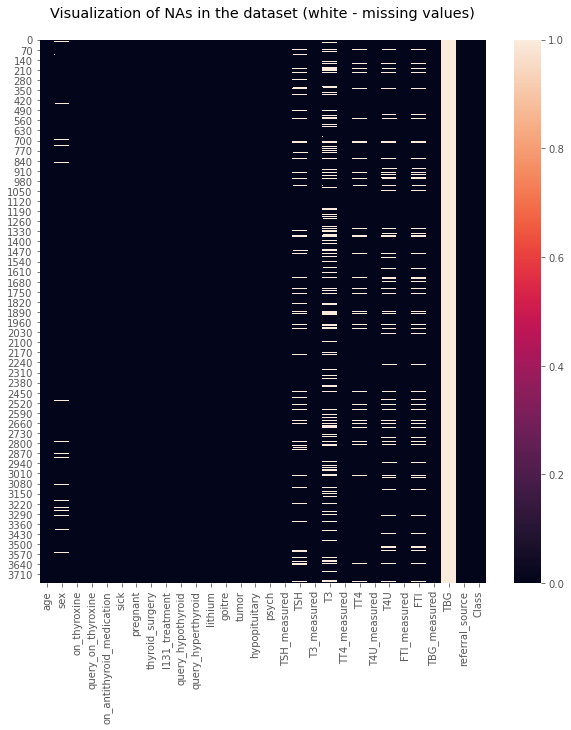

In [6]:
sns.heatmap(df.isna());
plt.title('Visualization of NAs in the dataset (white - missing values)\n');

We can see that the column "TBG" is entirely empty. We will drop it since it contains zero useful information. Good news: no missing values are present in the target variable. 

In [7]:
df = df.drop(['TBG'], axis=1)

### Train / Test Split

For the future models evaluation, we need to separate the training data and the test data. 

In [8]:
train, test = train_test_split(df, random_state=42, shuffle=True, test_size=0.25)

In [9]:
train.shape
test.shape

(2829, 29)

(943, 29)

Now random $\frac{3}{4}$ of the initial dataset is in the training set while the remaining $\frac{1}{4}$ is the test data. The further data analysis and the models tuning will be conducted with the training set to get closer to the real situation when the test data isn't available. The test set will be later used for the final evaluation of the models.

### FEATURES CATEGORIZATION

In [10]:
train.describe().T

,count,unique,top,freq
age,2828,92,59,74
sex,2713,2,F,1850
on_thyroxine,2829,2,False,2486
query_on_thyroxine,2829,2,False,2790
on_antithyroid_medication,2829,2,False,2797
sick,2829,2,False,2718
pregnant,2829,2,False,2791
thyroid_surgery,2829,2,False,2793
I131_treatment,2829,2,False,2785
query_hypothyroid,2829,2,False,2651


Most of the attributes are categorical Boolean, however, there are several numeric features that we can separate.  

In [11]:
NUMERICAL = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']
CATEGORICAL = train.drop([*NUMERICAL, 'Class'], axis=1).columns.tolist()
PREDICTORS = CATEGORICAL + NUMERICAL

In [12]:
for i in NUMERICAL:
    train[i] = pd.to_numeric(train[i])

<ipython-input-12-acf2fd671464>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i] = pd.to_numeric(train[i])


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2829 entries, 3571 to 3174
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        2828 non-null   float64
 1   sex                        2713 non-null   object 
 2   on_thyroxine               2829 non-null   object 
 3   query_on_thyroxine         2829 non-null   object 
 4   on_antithyroid_medication  2829 non-null   object 
 5   sick                       2829 non-null   object 
 6   pregnant                   2829 non-null   object 
 7   thyroid_surgery            2829 non-null   object 
 8   I131_treatment             2829 non-null   object 
 9   query_hypothyroid          2829 non-null   object 
 10  query_hyperthyroid         2829 non-null   object 
 11  lithium                    2829 non-null   object 
 12  goitre                     2829 non-null   object 
 13  tumor                      2829 non-null   ob

## EDA

### TARGET ANALYSIS

**TARGET UNIVARIATE ANALYSIS**

Firtsltly, we want to understand the distribution of the target to check how well-balanced the data is. This information might be useful for the regression step.  

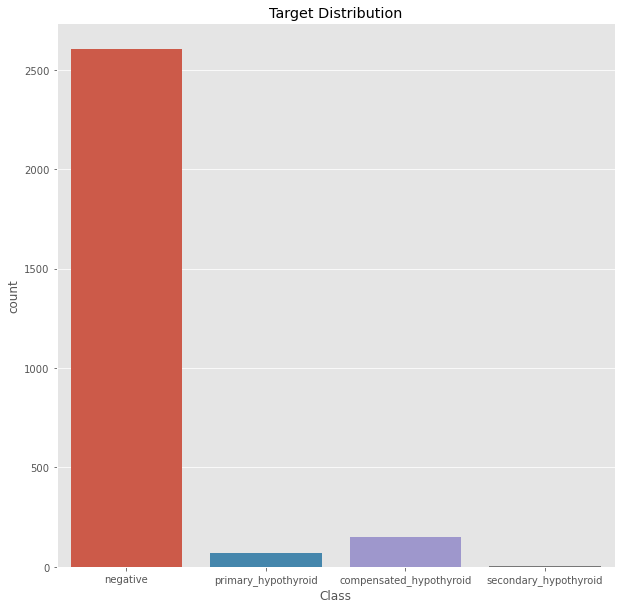

In [14]:
ax = sns.countplot(x=train.Class)
ax.set_title('Target Distribution');

In [15]:
train.Class.value_counts()

negative                   2603
compensated_hypothyroid     152
primary_hypothyroid          72
secondary_hypothyroid         2
Name: Class, dtype: int64

There are extremely few secondary_hypothyroid positive cases — the number considerably smaller than the number of predictors and even potential cross-validation splits. It would be impossible not to overfit the model in respect to this category of the target, which is why we drop it to conventrate on the other positive cases. 

In [16]:
target = train.Class
secondary_hypo_idc = (target =='secondary_hypothyroid')
train = train.loc[~secondary_hypo_idc]

We can clearly see that the dataset is imbalanced with respect to the target variable. The proportion of negative cases, i.e. with no detected hypothyroid, is by far the majority compared with the positive cases. This creates a problem of representing all classes in the training set so that the model learns to correctly classify not only negatives but also distinguish between the types of positive target values.    

Based on the target distribution and the overall research aim, we will choose the metrics that will focus on the positive diagnosis. That is, we want the model not to miss positive cases, even if that requires misclassifying some negative observations into False Positives. The logic is that it is much less costly for a patient to be diagnosed two times than to send one home and hope that the model was right while the true diagnose was positive. 

**TARGET BIVARIATE ANALYSIS**

In this section, we want to have a preliminary check of the relationships between the target variable and the predictors. In our case, we have two groups of predictors: categorical and numerical. 

*Categorical predictors*

With the categorical predictors, percentage coutplots are shown to compare the differences in distribution of these predictors for corresponding target values. 

In [17]:
train_plot = train.fillna(value='Unknown')

Text(0.5, 1.0, 'sex percentage distribution vs target')

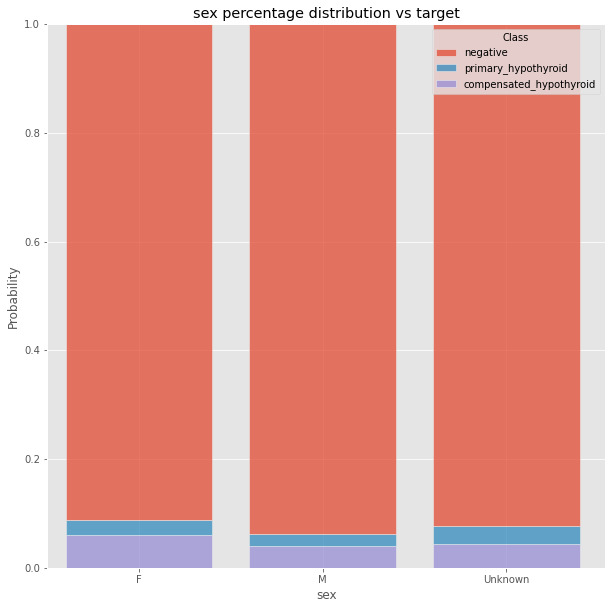

Text(0.5, 1.0, 'on_thyroxine percentage distribution vs target')

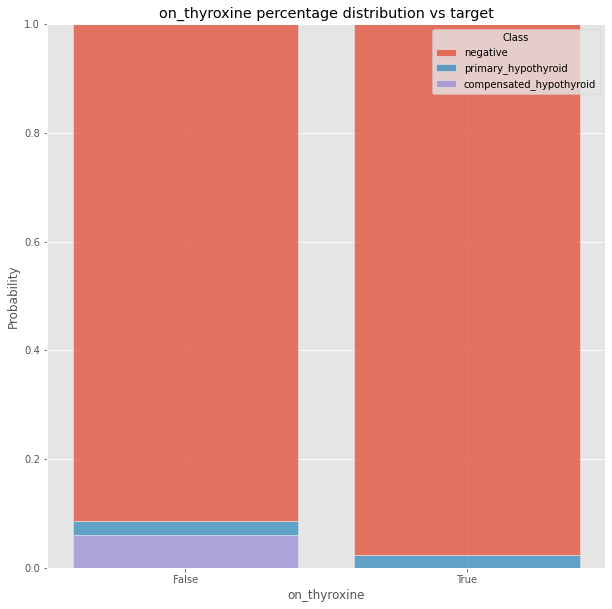

Text(0.5, 1.0, 'query_on_thyroxine percentage distribution vs target')

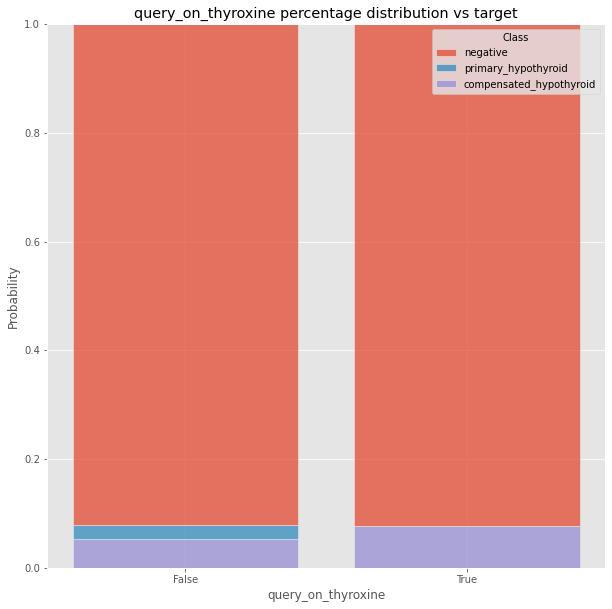

Text(0.5, 1.0, 'on_antithyroid_medication percentage distribution vs target')

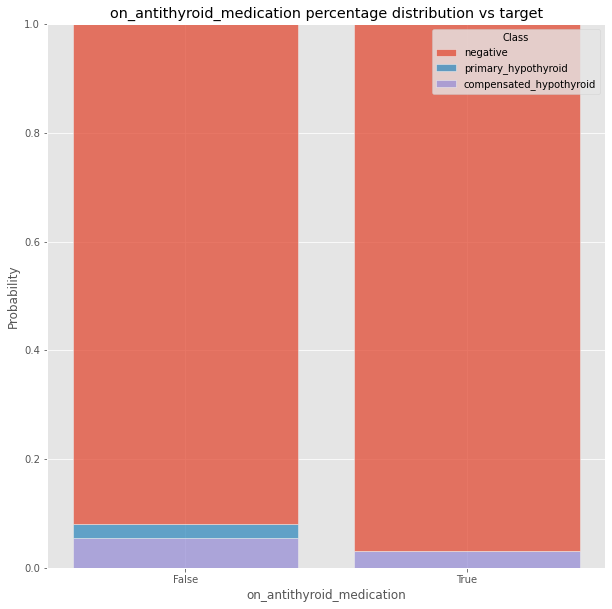

Text(0.5, 1.0, 'sick percentage distribution vs target')

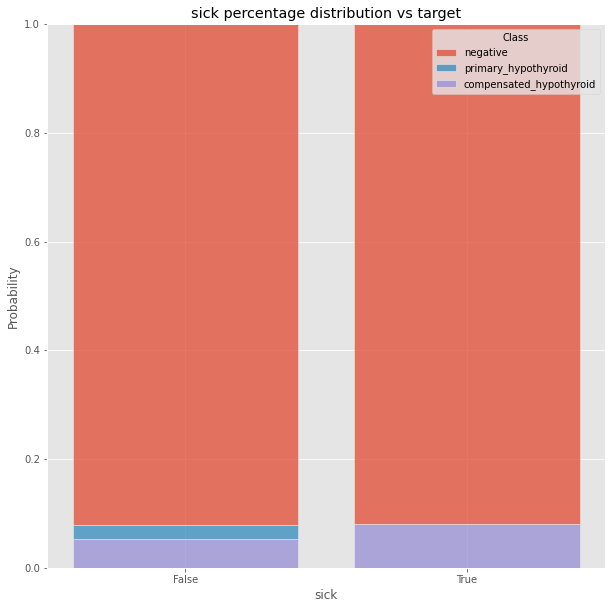

Text(0.5, 1.0, 'pregnant percentage distribution vs target')

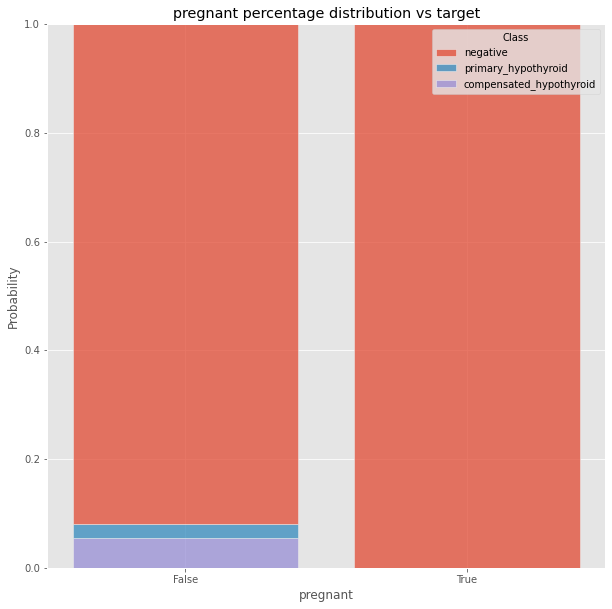

Text(0.5, 1.0, 'thyroid_surgery percentage distribution vs target')

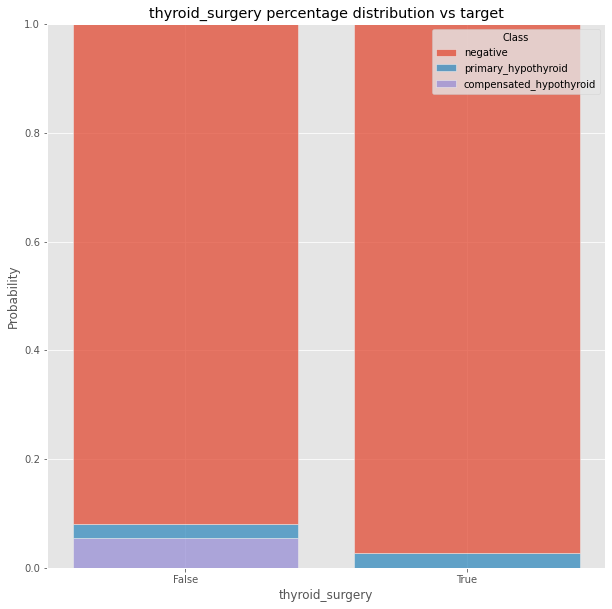

Text(0.5, 1.0, 'I131_treatment percentage distribution vs target')

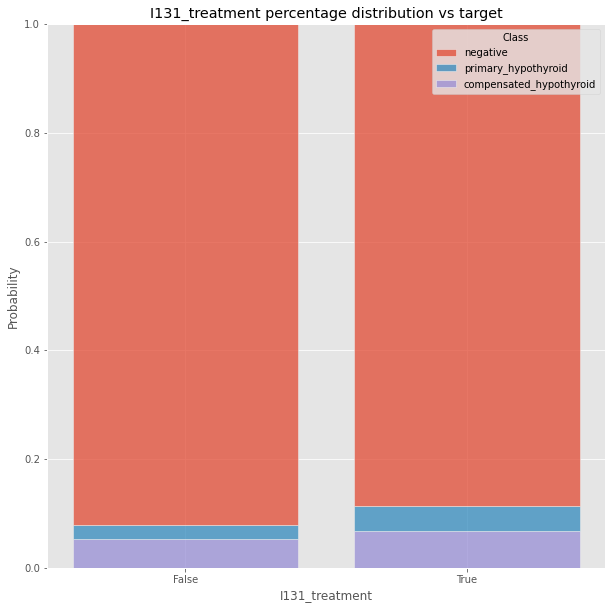

Text(0.5, 1.0, 'query_hypothyroid percentage distribution vs target')

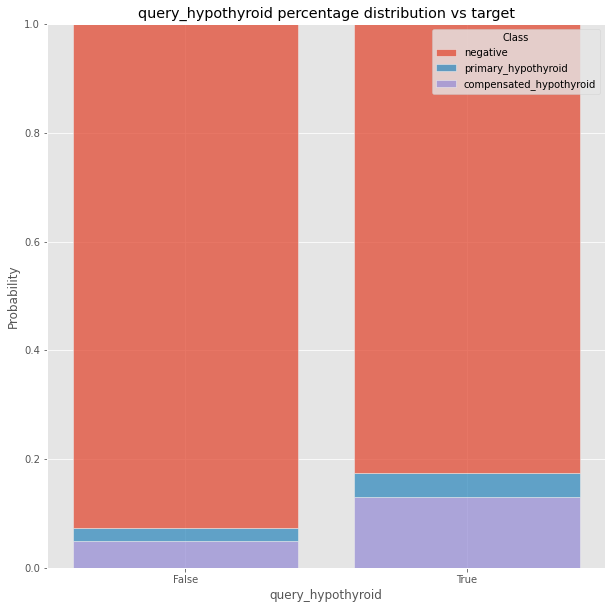

Text(0.5, 1.0, 'query_hyperthyroid percentage distribution vs target')

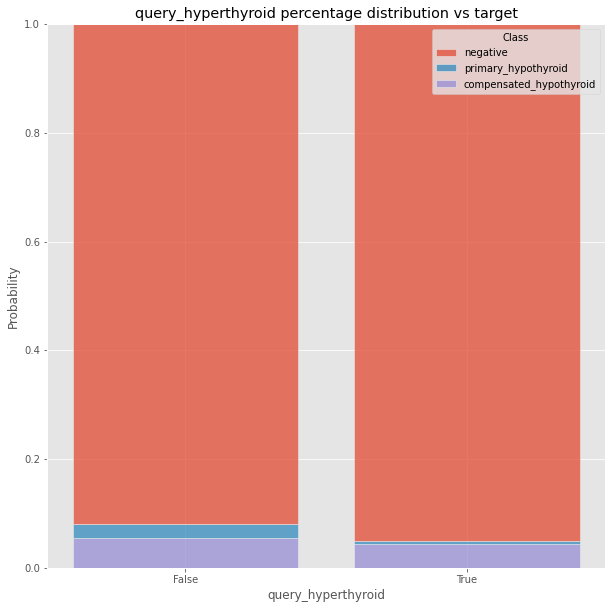

Text(0.5, 1.0, 'lithium percentage distribution vs target')

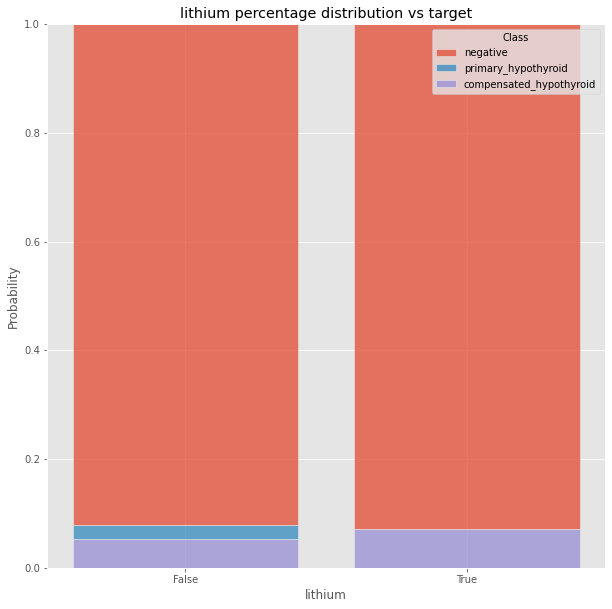

Text(0.5, 1.0, 'goitre percentage distribution vs target')

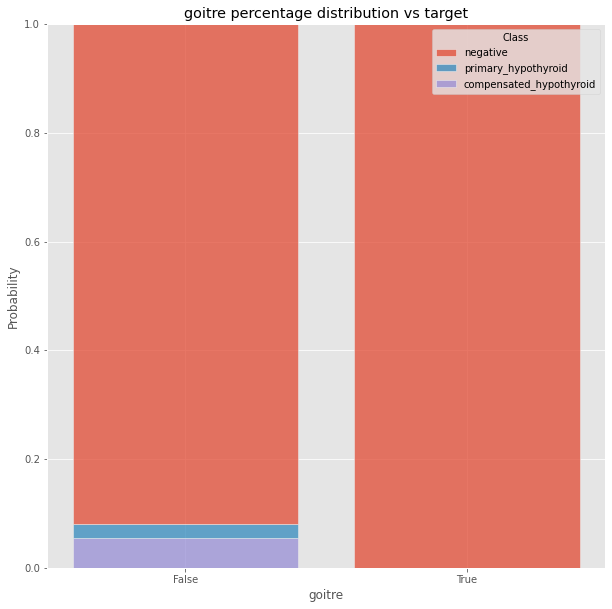

Text(0.5, 1.0, 'tumor percentage distribution vs target')

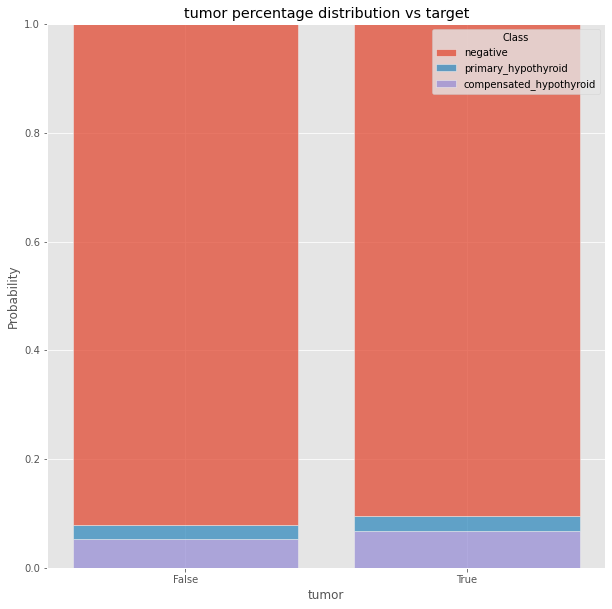

Text(0.5, 1.0, 'hypopituitary percentage distribution vs target')

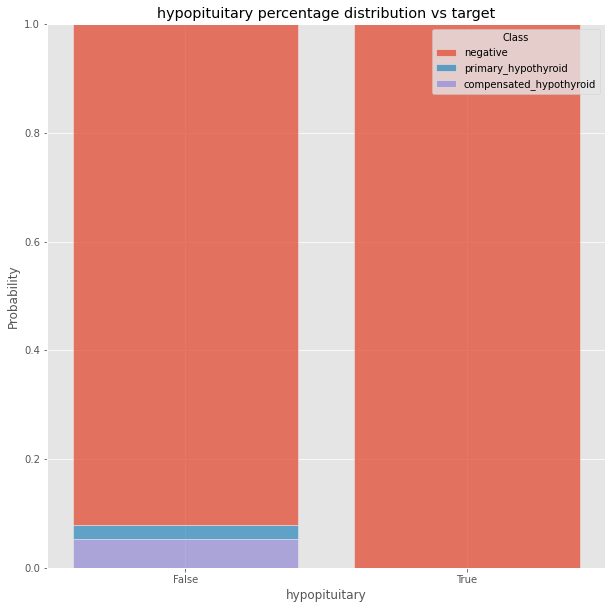

Text(0.5, 1.0, 'psych percentage distribution vs target')

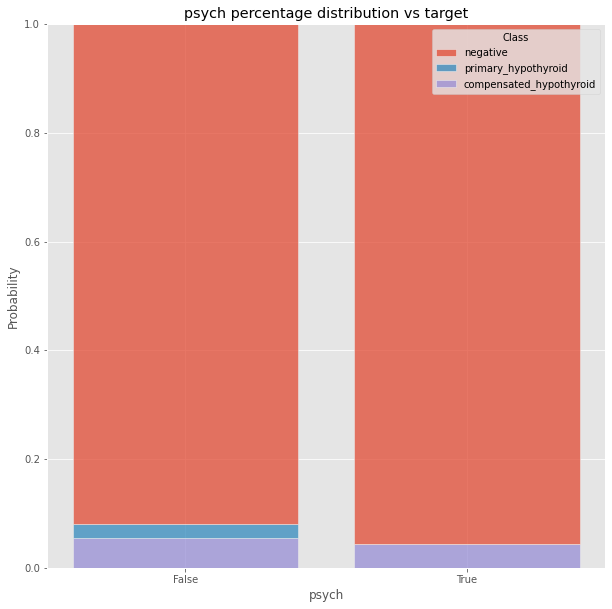

Text(0.5, 1.0, 'TSH_measured percentage distribution vs target')

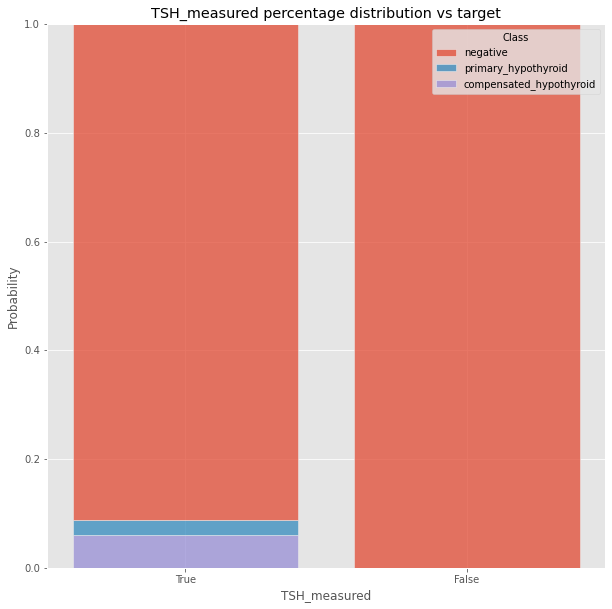

Text(0.5, 1.0, 'T3_measured percentage distribution vs target')

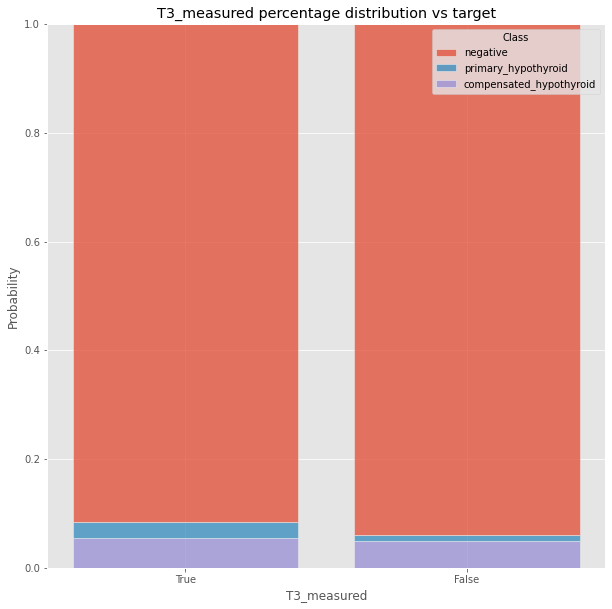

Text(0.5, 1.0, 'TT4_measured percentage distribution vs target')

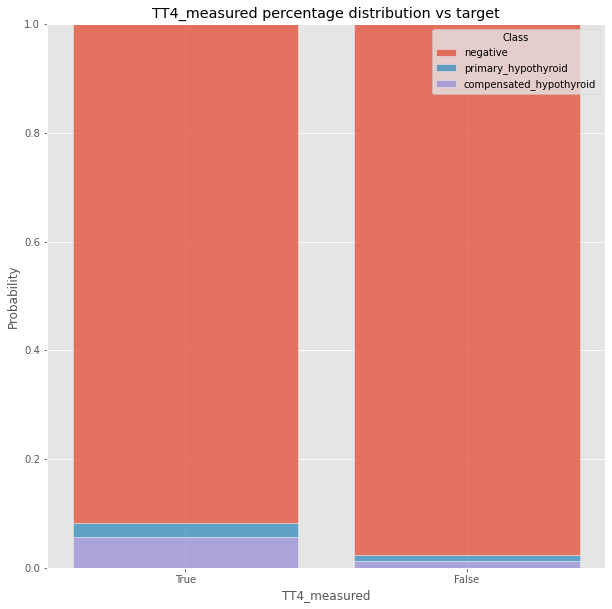

Text(0.5, 1.0, 'T4U_measured percentage distribution vs target')

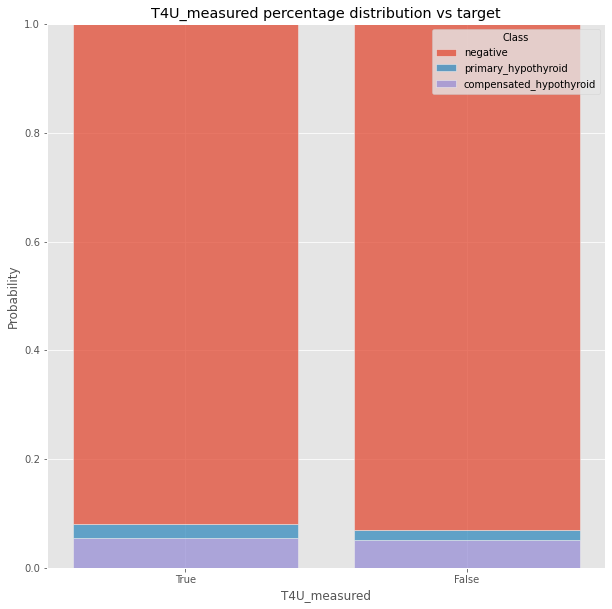

Text(0.5, 1.0, 'FTI_measured percentage distribution vs target')

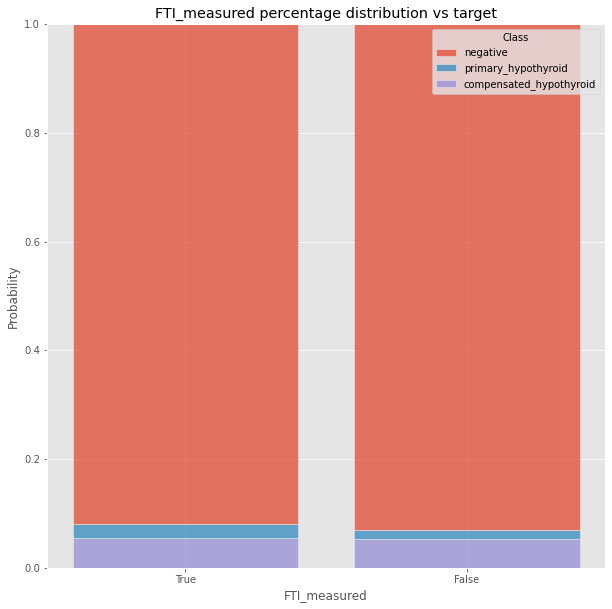

Text(0.5, 1.0, 'TBG_measured percentage distribution vs target')

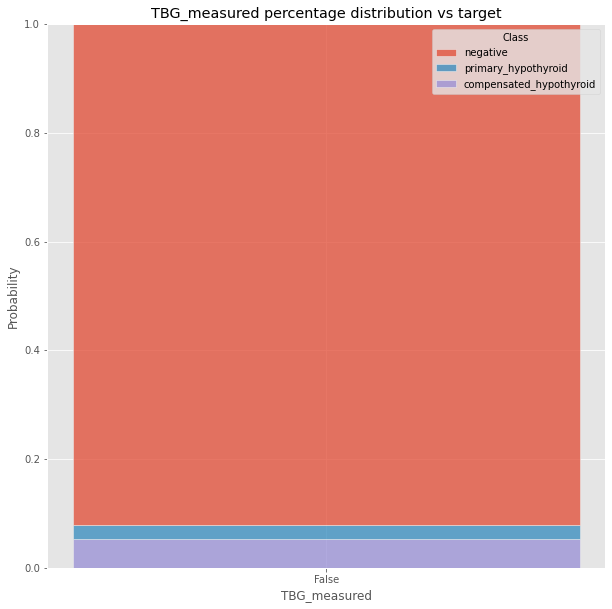

Text(0.5, 1.0, 'referral_source percentage distribution vs target')

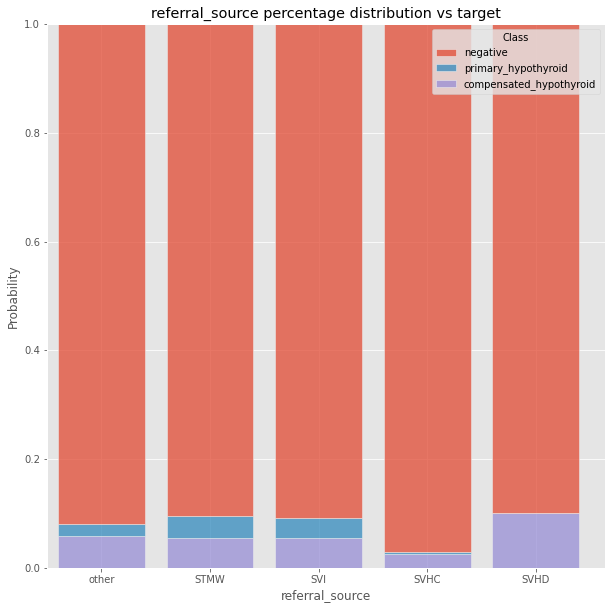

In [18]:
for i in CATEGORICAL: 
    ax = sns.histplot(data=train_plot, x=i, hue="Class", stat="probability", multiple="fill", shrink=.8)
    ax.set_title("{} percentage distribution vs target".format(i))
    
    plt.show();

INTERPRETATION:
- `sex`. On average, female patients in the dataset are diagnosed with positive hypothyroid more often than the male patients. Moreover, female patients seem to have higher proportion of compensated hypotheroid relative to other diagnoses compared with the male patients. This, however, does not take into account the observations where the sex is unknown.  
- `on_thyroxine`. 
- `query_on_thyroxine`. Patients with FALSE value of the variable seem to be diagnosed with primary hypotheroid compared with the ones with TRUE value. 
- `on_antithyroid_medication`. Patients with FALSE value of the variable seem to be diagnosed with primary hypotheroid compared with the ones with TRUE value. 
- `pregnant`. Seems like none of the diagnozed pregnant women had positive cases. 
- `query_hyperthyroid`. This variable seems to capture all the positive types of hypotheroid in percentages larger than any other categorical variable. 
- `TBG_measured`. Only has a single value of 'False'. We drop this column.
- `referral_source`. Considerint positive cases, 'SVHD' is exclusively associated with compensated hypotheroid.

In [19]:
df = df.drop(['TBG_measured'], axis=1)
train = train.drop(['TBG_measured'], axis=1)
test = test.drop(['TBG_measured'], axis=1)
CATEGORICAL.remove('TBG_measured')
PREDICTORS = CATEGORICAL + NUMERICAL

*Numerical predictors*

Text(0.5, 1.0, 'age boxplot with the target')

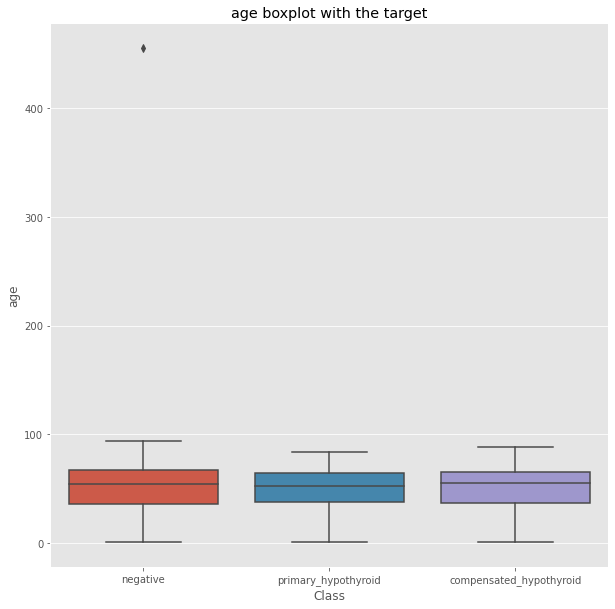

Text(0.5, 1.0, 'TSH boxplot with the target')

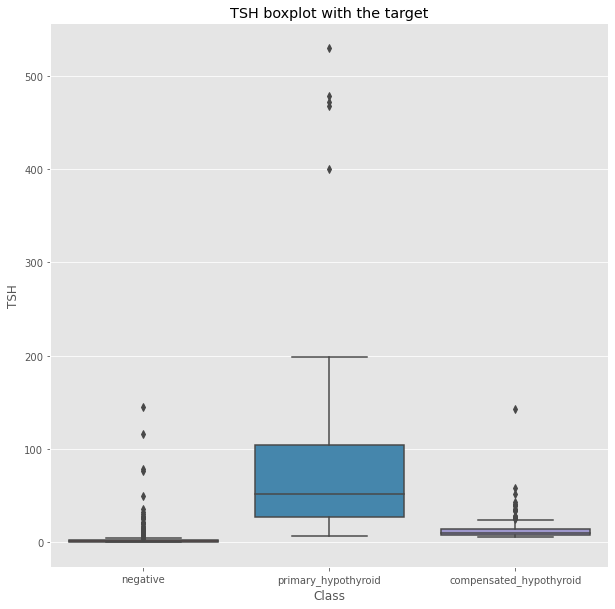

Text(0.5, 1.0, 'T3 boxplot with the target')

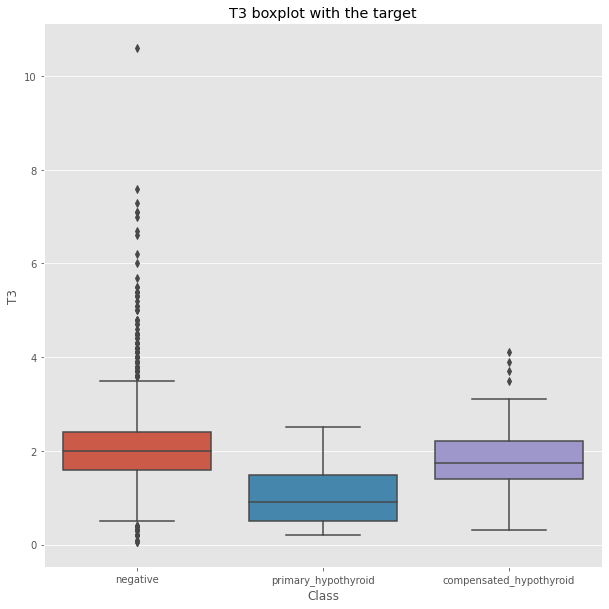

Text(0.5, 1.0, 'TT4 boxplot with the target')

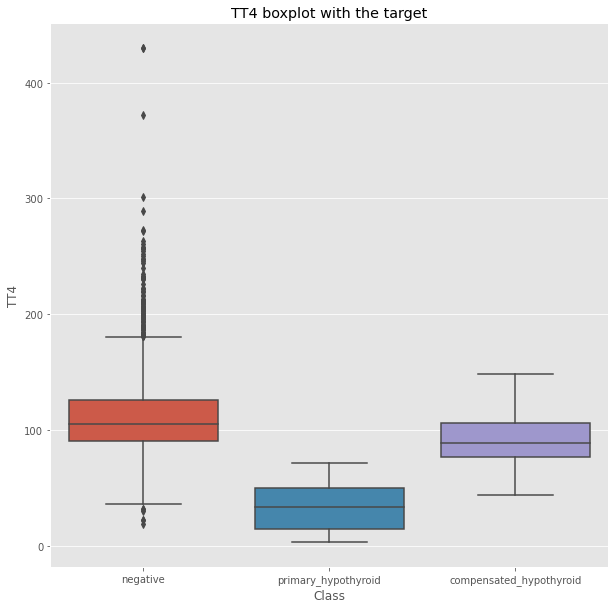

Text(0.5, 1.0, 'T4U boxplot with the target')

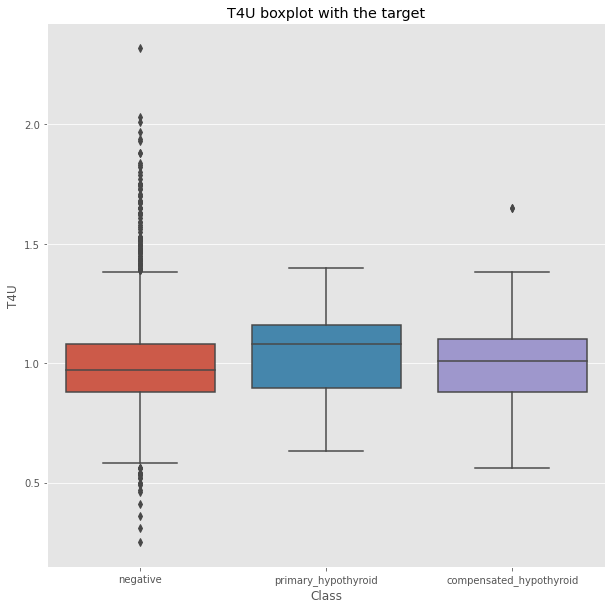

Text(0.5, 1.0, 'FTI boxplot with the target')

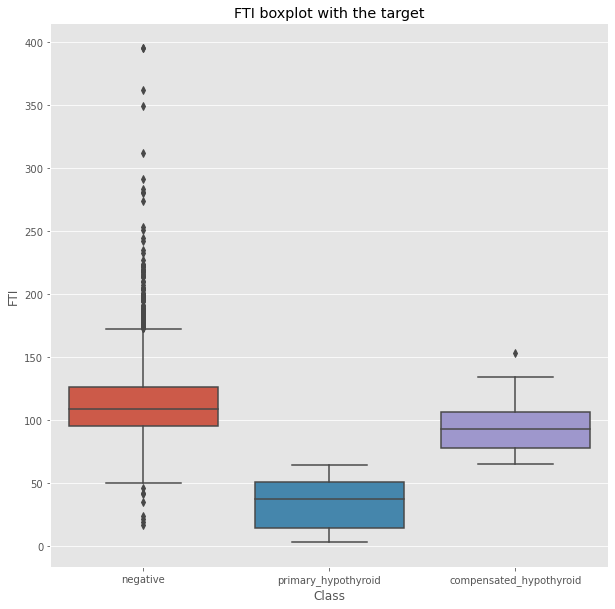

In [20]:
for i in NUMERICAL:
    ax = sns.boxplot(x=train['Class'], y=train[i], data=train)
    ax.set_title("{} boxplot with the target".format(i))
    
    plt.show();

INTERPRETATION:
- `Age`. We can see a clear outlier with `Age`>450. There is a slight tendency that primary hypothyroid is observed with younger patients.  
- `TSH`. It is clear that primary hypothyroid is distinguishly associated with `TSH`. 
- `T3`. Meanwhile, primary hypothyroid patients exhibit relatively lower values of `T3` compared to other groups.
- `T4`. Primary hypothyroid exhibits lower observed values of `T4` compared with negative and compensated hypothyroid cases.
- `T4U`. It can be argued that `T4U` values are higher for those with primary hypothyroid, but the association is not very strong.
- `FTI`. We can see that there might be a trend that patients with hypothyroid exhibit lower values of `FTI`. 

### PREDICTORS ANALYSIS

**UNIVARIATE ANALYSIS**

In this section, we want to check the distributions of the sole predictors. 

*Categorical*

Text(0.5, 1.05, 'sex distribution')

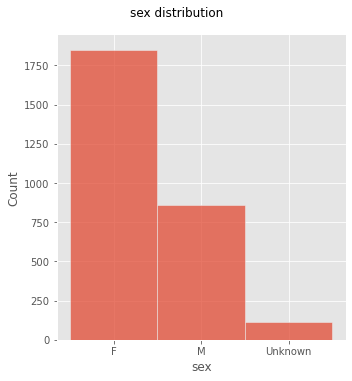

Text(0.5, 1.05, 'on_thyroxine distribution')

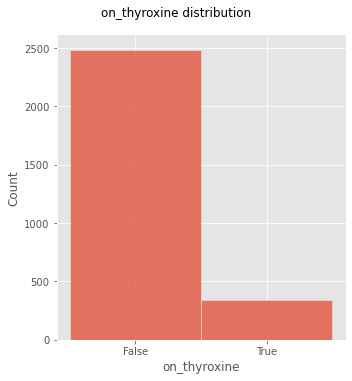

Text(0.5, 1.05, 'query_on_thyroxine distribution')

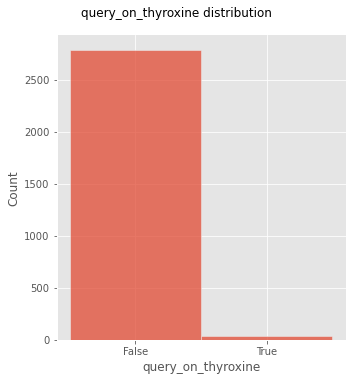

Text(0.5, 1.05, 'on_antithyroid_medication distribution')

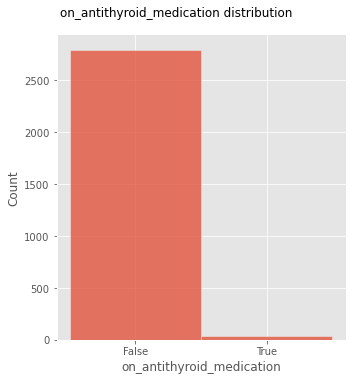

Text(0.5, 1.05, 'sick distribution')

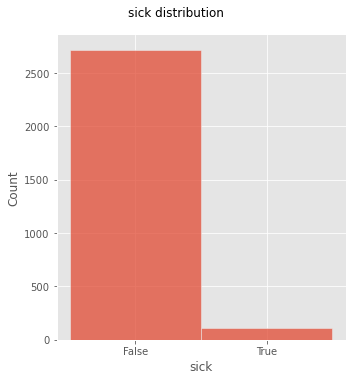

Text(0.5, 1.05, 'pregnant distribution')

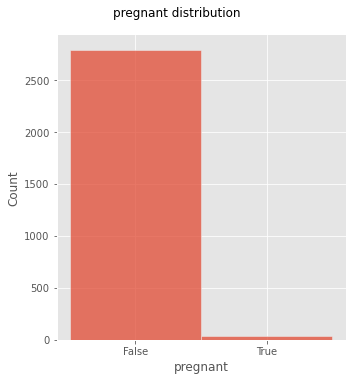

Text(0.5, 1.05, 'thyroid_surgery distribution')

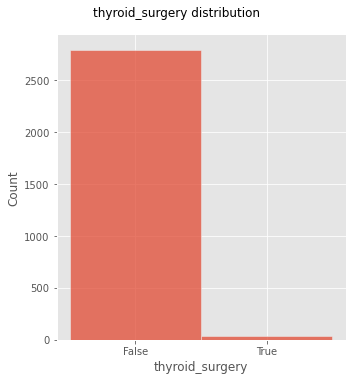

Text(0.5, 1.05, 'I131_treatment distribution')

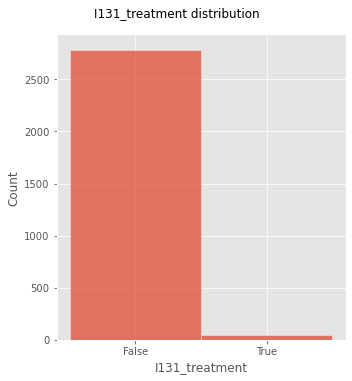

Text(0.5, 1.05, 'query_hypothyroid distribution')

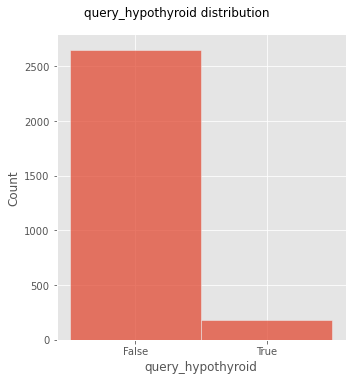

Text(0.5, 1.05, 'query_hyperthyroid distribution')

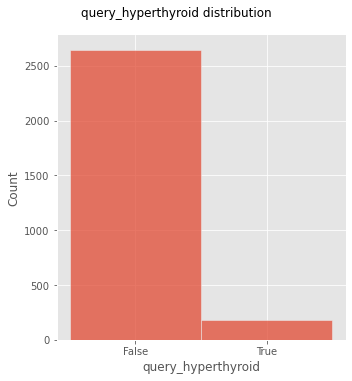

Text(0.5, 1.05, 'lithium distribution')

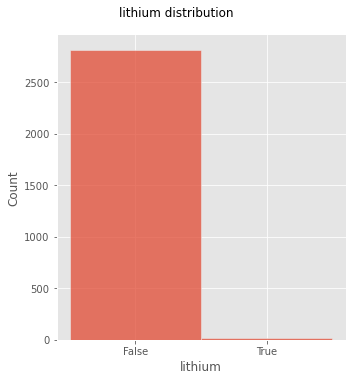

Text(0.5, 1.05, 'goitre distribution')

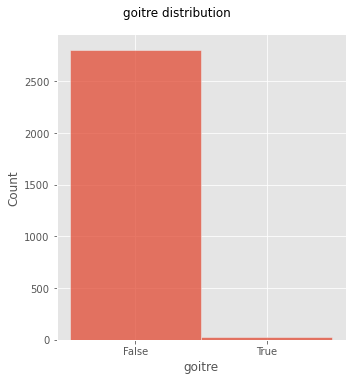

Text(0.5, 1.05, 'tumor distribution')

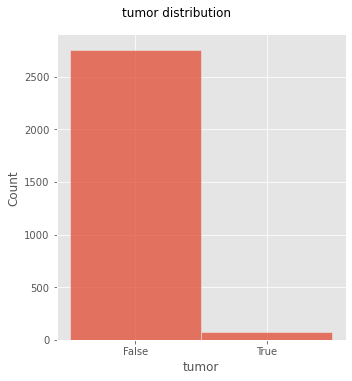

Text(0.5, 1.05, 'hypopituitary distribution')

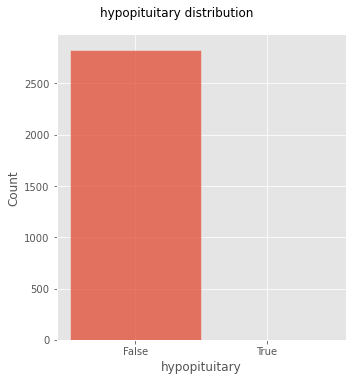

Text(0.5, 1.05, 'psych distribution')

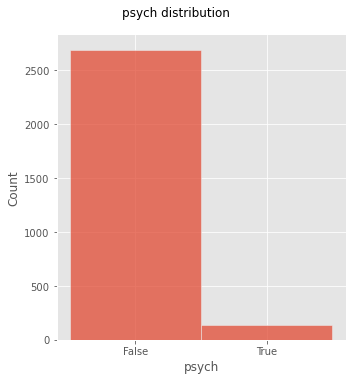

Text(0.5, 1.05, 'TSH_measured distribution')

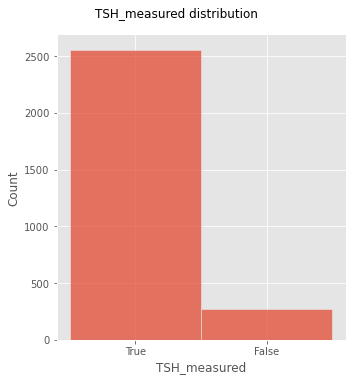

Text(0.5, 1.05, 'T3_measured distribution')

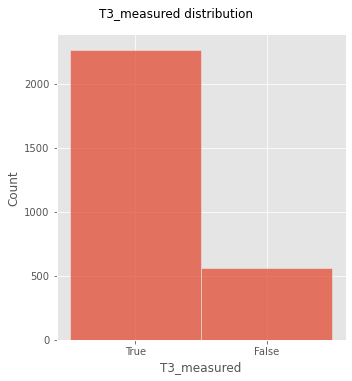

Text(0.5, 1.05, 'TT4_measured distribution')

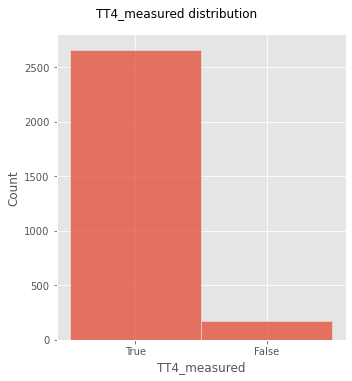

Text(0.5, 1.05, 'T4U_measured distribution')

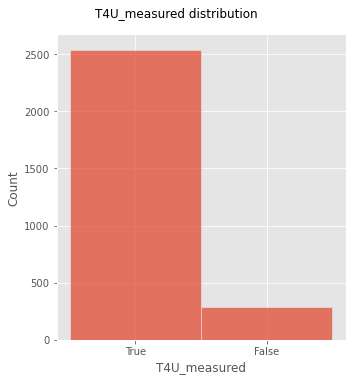

Text(0.5, 1.05, 'FTI_measured distribution')

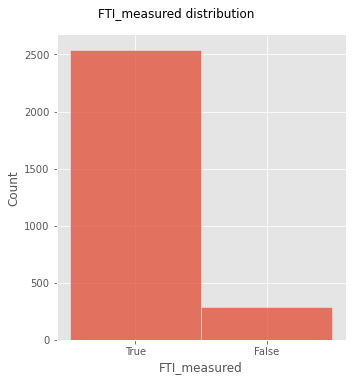

Text(0.5, 1.05, 'referral_source distribution')

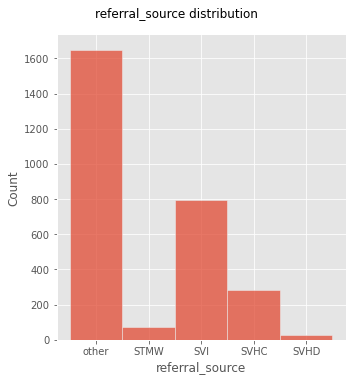

In [21]:
for i in CATEGORICAL:
    figure = plt.figure
    ax = sns.displot(train_plot[i])
    ax.fig.suptitle("{} distribution".format(i), y=1.05)
        
    plt.show();

INTERPRETATION: 
- `TBG_measured` is a one-value column with only False values. We can drop this column since it doesn't provide any explanation of the target variance.
- Mostly all the categorical features are distrbuted non-uniformly with a large propotion of them having a value of 'False'. This means it is not a good idea to impute the mode value since it could result in lost of potentially useful variance of the categorical variables.

*Numerical*

Text(0.5, 1.05, 'age distribution')

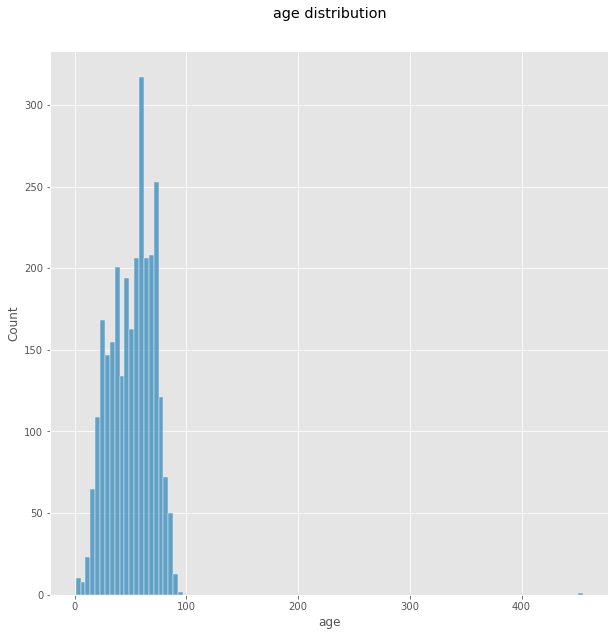

Text(0.5, 1.05, 'TSH distribution')

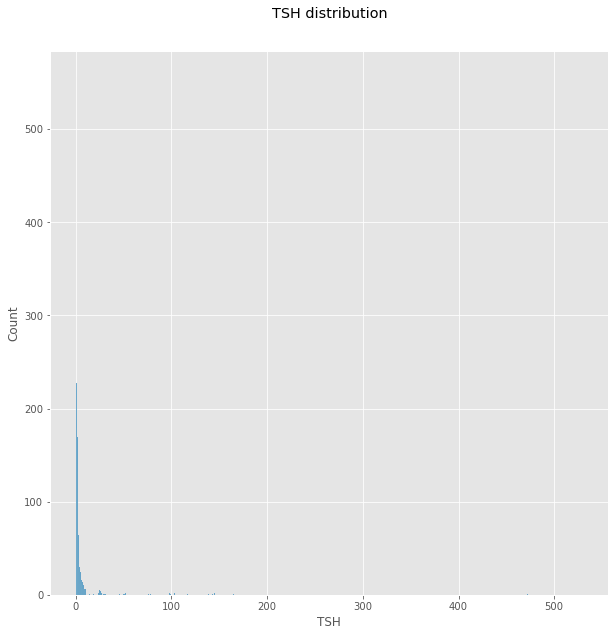

Text(0.5, 1.05, 'T3 distribution')

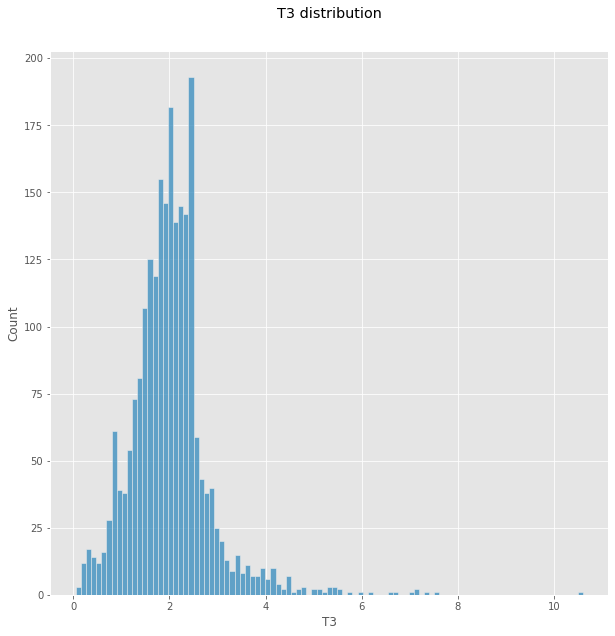

Text(0.5, 1.05, 'TT4 distribution')

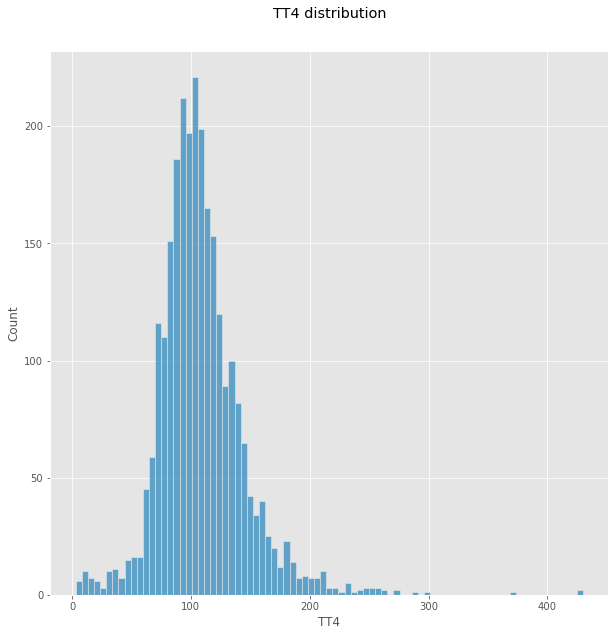

Text(0.5, 1.05, 'T4U distribution')

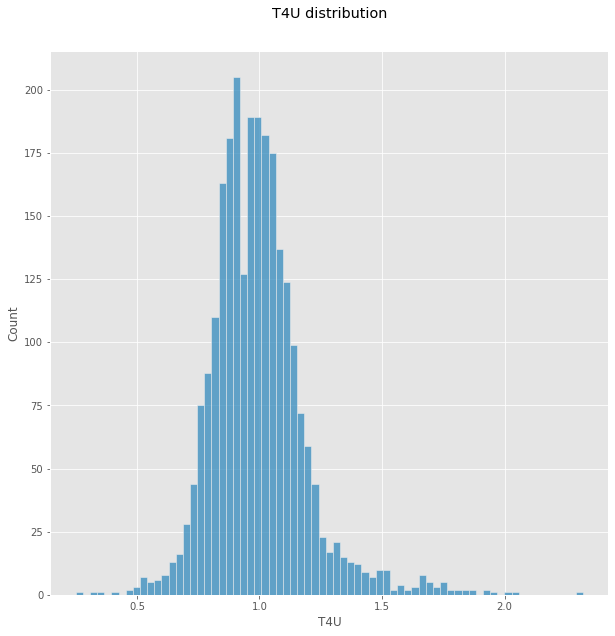

Text(0.5, 1.05, 'FTI distribution')

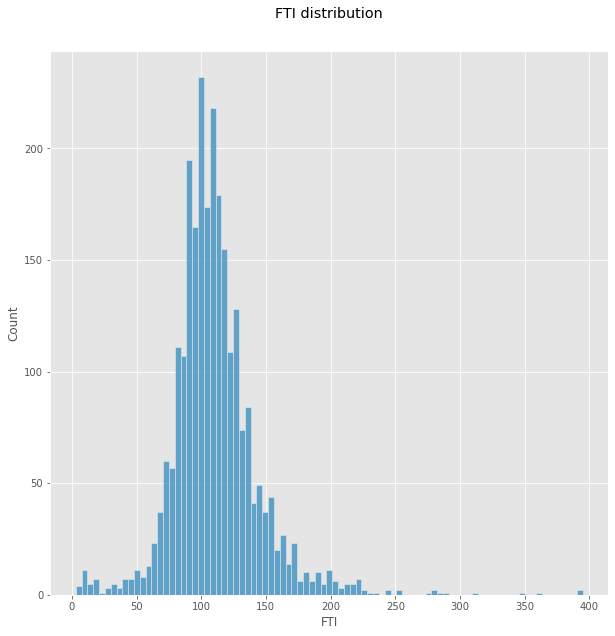

In [22]:
for i in NUMERICAL:
    ax = sns.histplot(train[i])
    ax.set_title("{} distribution".format(i), y=1.05)
        
    plt.show();

INTERPRETATION:
- We can see that the distributions of the numerical features are mostly skewed. For that reason we will use RobustScaler and the median value for missing values imputation.

**MULTIVARIATE ANALYSIS**

Here we check how the predictors are associated with each other. 

*Numerical features*

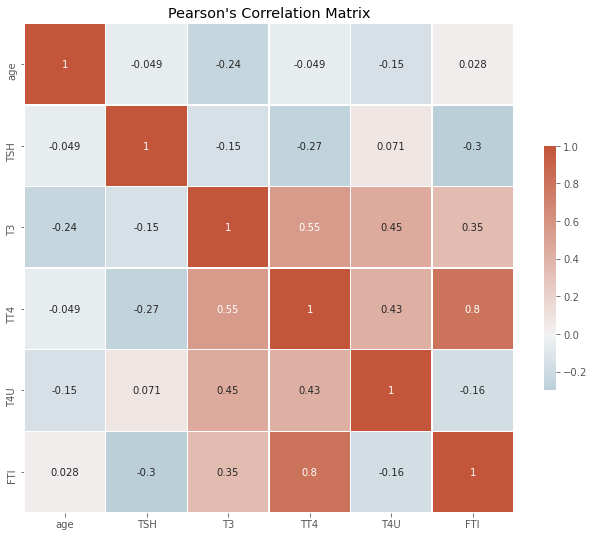

In [23]:
corr = train[NUMERICAL].corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_title("Pearson's Correlation Matrix");

In general, we see that the numerical features are not highly correlated with each other. However, there are several exceptions that we need to pay attention to. 
- `T3` and `TT4` corr = +0.55
- `FTI` and `TT4` corr = +0.8

It is important to keep an eye on them due to potential multicollinearity issues.

## DATA PREPROCESSING

## Remove Outliers

In [24]:
outliers_ind = (train.age > 100)
train = train.loc[~outliers_ind]

## CV Split

In [25]:
train, test = train_test_split(train, random_state=42, shuffle=True, test_size = 0.2)

## Create Pipeline

In [26]:
numerical_def = gen_features(
    columns=[[c] for c in NUMERICAL],
    classes=[
        {'class': SimpleImputer, 'strategy': 'median'},
        {'class': RobustScaler}
    ]
)

categorical_def = gen_features(
    columns=[[c] for c in CATEGORICAL],
    classes=[
        {'class': SimpleImputer, 'strategy': 'constant', 'fill_value': 'Unknown'},
        {'class': OneHotEncoder, 'handle_unknown': 'ignore'}
    ]    
)

In [27]:
features = numerical_def + categorical_def
mapper = DataFrameMapper(features)
len(features)

27

In [28]:
train_X, train_y = train.drop('Class', axis = 1), train['Class']
test_X, test_y = test.drop('Class', axis = 1), test['Class']

In [29]:
train_X_tr = pd.DataFrame(mapper.fit_transform(train_X))
test_X_tr = pd.DataFrame(mapper.transform(test_X))

## MODELS

### MODEL 1: LOGISTIC REGRESSION

In [30]:
model_1 = LogisticRegression(max_iter=1000)
model_1.fit(train_X_tr, train_y)

LogisticRegression(max_iter=1000)

In [31]:
y_pred_1 = model_selection.cross_val_predict(LogisticRegression(max_iter=1000), train_X_tr, train_y, cv=10)

In [32]:
print(classification_report(y_true=train_y, y_pred=y_pred_1))

                         precision    recall  f1-score   support

compensated_hypothyroid       0.75      0.25      0.38       118
               negative       0.96      0.99      0.98      2086
    primary_hypothyroid       0.85      0.79      0.81        56

               accuracy                           0.95      2260
              macro avg       0.85      0.68      0.72      2260
           weighted avg       0.94      0.95      0.94      2260



Given the specifics of the problem, we're interested in the Recall metric for positive cases. We can see, that the baseline model has the Recall metric values of 0.25 for compensated_hypothyroid and 0.79 for primary_hypothyroid. The same information can be displayed in a confusion matrix.

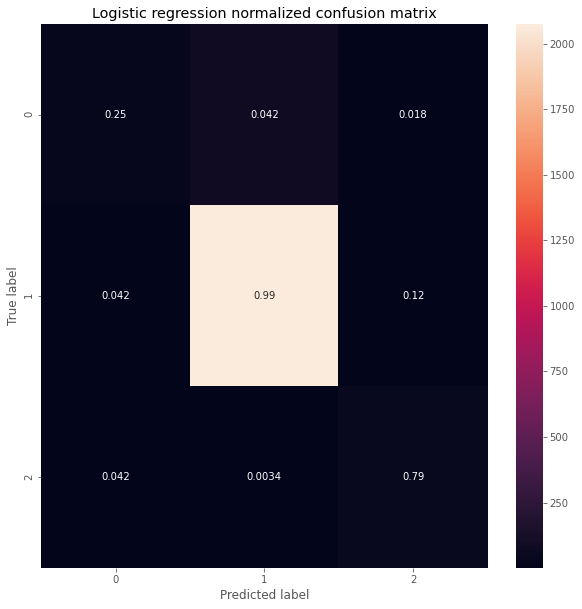

In [33]:
conf = confusion_matrix(y_true=train_y, y_pred=y_pred_1)
sns.heatmap(conf,
            annot=conf/np.sum(conf,axis=1))
plt.title('Logistic regression normalized confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label');

### MODEL 2: LOGISTIC REGRESSION WITH REGULARIZATION

--- Not present ---

### MODEL 3: K-nearest neighbours (KNN)

Due to the large number of dimensions, dimensionality reduction is required.

In [34]:
pca = PCA(n_components=5)
new_X_tr = pca.fit_transform(train_X_tr)
new_test_X_tr = pca.fit_transform(test_X_tr)

To choose the optimal k number, we will plot the CV-recall metric for various k values and see when the marginal increase in recall starts to diminish.

In [35]:
index=[]
recall_values=[]
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(new_X_tr, train_y)
    pred_i = knn.predict(new_test_X_tr)
    rec_i = metrics.recall_score(test_y, pred_i, average='micro')
    recall_values.append(rec_i)
    index.append(i)

KNeighborsClassifier(n_neighbors=1)

KNeighborsClassifier(n_neighbors=2)

KNeighborsClassifier(n_neighbors=3)

KNeighborsClassifier(n_neighbors=4)

KNeighborsClassifier()

KNeighborsClassifier(n_neighbors=6)

KNeighborsClassifier(n_neighbors=7)

KNeighborsClassifier(n_neighbors=8)

KNeighborsClassifier(n_neighbors=9)

KNeighborsClassifier(n_neighbors=10)

KNeighborsClassifier(n_neighbors=11)

KNeighborsClassifier(n_neighbors=12)

KNeighborsClassifier(n_neighbors=13)

KNeighborsClassifier(n_neighbors=14)

KNeighborsClassifier(n_neighbors=15)

KNeighborsClassifier(n_neighbors=16)

KNeighborsClassifier(n_neighbors=17)

KNeighborsClassifier(n_neighbors=18)

KNeighborsClassifier(n_neighbors=19)

KNeighborsClassifier(n_neighbors=20)

KNeighborsClassifier(n_neighbors=21)

KNeighborsClassifier(n_neighbors=22)

KNeighborsClassifier(n_neighbors=23)

KNeighborsClassifier(n_neighbors=24)

KNeighborsClassifier(n_neighbors=25)

KNeighborsClassifier(n_neighbors=26)

KNeighborsClassifier(n_neighbors=27)

KNeighborsClassifier(n_neighbors=28)

KNeighborsClassifier(n_neighbors=29)

KNeighborsClassifier(n_neighbors=30)

KNeighborsClassifier(n_neighbors=31)

KNeighborsClassifier(n_neighbors=32)

KNeighborsClassifier(n_neighbors=33)

KNeighborsClassifier(n_neighbors=34)

KNeighborsClassifier(n_neighbors=35)

KNeighborsClassifier(n_neighbors=36)

KNeighborsClassifier(n_neighbors=37)

KNeighborsClassifier(n_neighbors=38)

KNeighborsClassifier(n_neighbors=39)

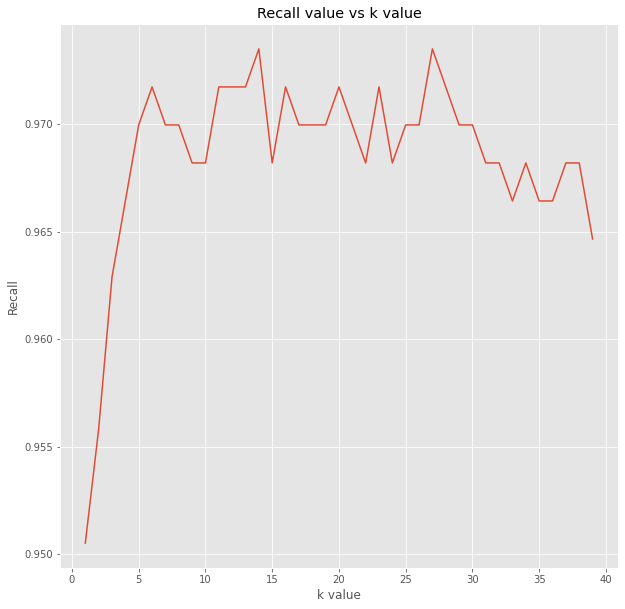

In [36]:
fig = sns.lineplot(x=index, y=recall_values)
fig.set_title('Recall value vs k value')
fig.set_xlabel('k value')
fig.set_ylabel('Recall');

It can be seen that the optimal value of k is 6. 

In [37]:
neigh_6 = KNeighborsClassifier(n_neighbors=6)

In [38]:
neigh_6.fit(new_X_tr, train_y)

KNeighborsClassifier(n_neighbors=6)

In [39]:
predict_neigh = neigh_6.predict(new_test_X_tr)
print(classification_report(y_true=test_y, y_pred=predict_neigh))

                         precision    recall  f1-score   support

compensated_hypothyroid       0.75      0.79      0.77        34
               negative       0.99      0.99      0.99       516
    primary_hypothyroid       0.87      0.81      0.84        16

               accuracy                           0.97       566
              macro avg       0.87      0.86      0.87       566
           weighted avg       0.97      0.97      0.97       566



The chosen k value of 6 yields recall measures for compensated_hypothyroid and primary_hypothyroid equal to 0.79 and 0.81 correspondingly. That means that the KNN method works better for detecting both positive cases of hypothyroid compared to baseline logistic regression. 

**POTENTIAL IMPROVEMENTS:**
- Transform several numeric predictors that are not distributed normally. Maybe try another scaling transformation.
- Perform a comprehensive outlier removal procedure, not just one of them. 
- Perform hyperparameters tuning for the logistic regression. Also, perform the final evaluation with the test set.  
- Create a logistic model with regularization.
- Choose the best number of PCs in the dimensionality reduction step based on the dynamics of % of the explained variance.
- Considering other ways to increase the recall metric.